In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import linalg
import random
from tabulate import tabulate


In [2]:
# A.1.

np.random.seed(42)
def GetData(m,c,points):
  D1 , D2 , D3 = np.random.multivariate_normal(mean = m, cov = c , size = points).T
  W1 = np.vstack((D1,D2,D3)).T
  W1 = W1/np.sum(W1)
  return W1

def DataSplit(Data,ratio):
  trainind = random.sample(range(0,len(Data)),k = int((1-ratio)*Data.shape[0]))
  testind = [i for i in range(Data.shape[0]) if i not in trainind]
  Train = Data[trainind]
  Test = Data[testind]
  return Train, Test
  
points = 1000
m = [0, 0 , 0]
c = [[1 , 0.8 , 0.8],[0.8 , 1 , 0.8],[0.8 , 0.8 , 1]]

X = GetData(m,c,points)
print('\nData Shape : ',X.shape)
print('\nFew Samples from data : \n\n',X[:5])

test_size = 0.2
X_train , X_test = DataSplit(X,ratio=test_size)
print('\nX_train shape : ',X_train.shape)
print('\nX_test shape : ',X_test.shape)


Data Shape :  (1000, 3)

Few Samples from data : 

 [[ 0.00147043  0.00349488  0.00406405]
 [ 0.0097851   0.00846845  0.00943235]
 [ 0.01068486  0.01059076  0.00743158]
 [ 0.00439448  0.0017803   0.00368798]
 [ 0.00556574 -0.00452171  0.0033544 ]]

X_train shape :  (800, 3)

X_test shape :  (200, 3)


In [3]:
# A.2
np.random.seed(42)

class Autoencoder():

  def __init__(self,num_hidden_neurons,input_shape,lr,epochs,test):
    self.num_hidden_neurons = num_hidden_neurons
    self.W1 = np.random.rand(num_hidden_neurons,input_shape[1])
    self.W2 = np.random.rand(input_shape[1],num_hidden_neurons)
    self.b2 = np.random.rand(num_hidden_neurons,)
    self.b3 = np.random.rand(input_shape[1],)
    self.lr = lr
    self.epochs = epochs
    self.X_test = test.T
    self.trainloss = []
    self.testloss = []

  def Forward_Pass(self,X):
    a1 = X
    if len(X.shape)>1:
      a2 = 1/(1+np.exp(-(np.dot(self.W1,a1) + self.b2.reshape(-1,1))))
      a3 = 1/(1+np.exp(-(np.dot(self.W2,a2) + self.b3.reshape(-1,1))))
    else :
      a2 = 1/(1+np.exp(-(np.dot(self.W1,a1) + self.b2)))
      a3 = 1/(1+np.exp(-(np.dot(self.W2,a2) + self.b3)))
    return a1,a2,a3  

  def GetMSE(self,X,Y):
    mse = np.mean(np.mean(np.square(X-Y),axis=0))
    return mse  
  
  def Fit(self,X):

    print('Training : ')
    for e in range(self.epochs):
      for i in range(X.shape[0]):

        a1,a2,a3 = self.Forward_Pass(X[i])
        d3 = np.multiply(np.multiply(-(X[i]-a3),a3),1-a3).reshape(-1,1)   # For MSE
        d2 = np.multiply(np.dot(self.W2.T,d3),np.multiply(a2,1-a2).reshape(-1,1))
        
        self.W2 = self.W2 - (self.lr*np.dot(d3,a2.reshape(-1,1).T))
        self.W1 = self.W1 - (self.lr*np.dot(d2,a1.reshape(-1,1).T))
        self.b3 = self.b3 - (self.lr*d3.ravel())
        self.b2 = self.b2 - (self.lr*d2.ravel())

      self.trainloss.append(self.GetMSE(self.Predict(X.T),X))
      self.testloss.append(self.GetMSE(self.Predict(self.X_test),self.X_test.T))    
      print('Epoch : '+str(e+1)+', Train MSE : '+str(self.GetMSE(self.Predict(X.T),X))+', Test MSE : '+str(self.GetMSE(self.Predict(self.X_test),self.X_test.T)))  

  def Predict(self,X):
    a1,a2,a3 = self.Forward_Pass(X)
    return a3.T

  def Plot(self):
    plt.figure(figsize=(7,7))
    plt.plot(range(1,len(self.trainloss)+1),self.trainloss,label = 'Training Loss')
    plt.plot(range(1,len(self.testloss)+1),self.testloss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Loss')
    plt.legend()
    plt.show()


In [4]:
# Pass X_test as X_test.T
ae = Autoencoder(num_hidden_neurons=2,input_shape=X.shape,lr = 0.3,epochs=100,test=X_test)
ae.Fit(X_train)   


Training : 
Epoch : 1, Train MSE : 0.0012884914656345573, Test MSE : 0.0012844000790495694
Epoch : 2, Train MSE : 0.0006160438843120877, Test MSE : 0.0006124749354356967
Epoch : 3, Train MSE : 0.0004093682073452386, Test MSE : 0.00040601359282737073
Epoch : 4, Train MSE : 0.0003101914836105172, Test MSE : 0.0003069597734010505
Epoch : 5, Train MSE : 0.00025226214898508155, Test MSE : 0.0002491122360769988
Epoch : 6, Train MSE : 0.0002143946894751599, Test MSE : 0.0002113040727644948
Epoch : 7, Train MSE : 0.00018775953316923632, Test MSE : 0.00018471436156164292
Epoch : 8, Train MSE : 0.0001680327913039331, Test MSE : 0.00016502384136828267
Epoch : 9, Train MSE : 0.00015285150521515657, Test MSE : 0.00014987227832582333
Epoch : 10, Train MSE : 0.000140816955157975, Test MSE : 0.0001378626732798935
Epoch : 11, Train MSE : 0.00013104917324134702, Test MSE : 0.00012811620440225777
Epoch : 12, Train MSE : 0.00012296728159470882, Test MSE : 0.0001200527900756304
Epoch : 13, Train MSE : 0.00

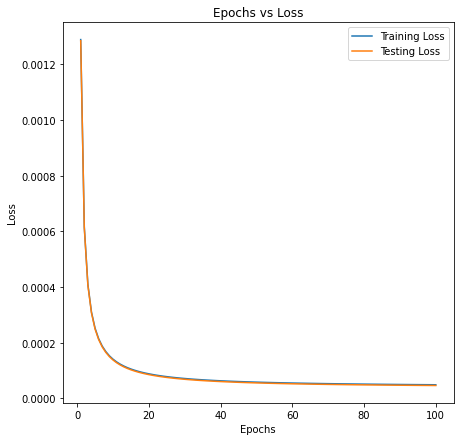

In [5]:
# A.3.
ae.Plot()

In [6]:
# A.4.

torch.manual_seed(42)

class TorchAE(nn.Module):

  def __init__(self,num_hidden_neurons,input_shape):
    super(TorchAE, self).__init__()
    self.hidden=nn.Linear(input_shape[1],num_hidden_neurons)
    self.output=nn.Linear(num_hidden_neurons,input_shape[1])

  def forward(self,X):
    return(torch.sigmoid(self.output(torch.sigmoid(self.hidden(X)))))

class AutoencoderTorch():

  def __init__(self,num_hidden_neurons,input_shape,lr,epochs,test):
    self.tae = TorchAE(num_hidden_neurons=num_hidden_neurons,input_shape=X.shape)
    self.opti = torch.optim.SGD(self.tae.parameters(), lr=lr)
    self.epochs = epochs
    self.X_test = test
    self.trainloss = []
    self.testloss = []

  def Fit(self,X):
    mse = nn.MSELoss()
    for epoch in range(self.epochs):
      for i in range(len(X)):
        self.opti.zero_grad()
        X_Cap = self.tae(X_train_tensor[i])
        MSE = mse(X_Cap,X_train_tensor[i])
        MSE.backward()
        self.opti.step()
      self.trainloss.append(mse(self.tae(X),X).item())
      self.testloss.append(mse(self.tae(self.X_test),self.X_test).item())

      
      print('Epoch : '+str(epoch+1)+', Train MSE : '+str(mse(self.tae(X),X).item())+', Test MSE : '+str(mse(self.tae(self.X_test),self.X_test).item()))  

  def Plot(self):
    plt.figure(figsize=(7,7))
    plt.plot(range(1,len(self.trainloss)+1),self.trainloss,label = 'Training Loss')
    plt.plot(range(1,len(self.testloss)+1),self.testloss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Loss')
    plt.legend()
    plt.show()    
 

Epoch : 1, Train MSE : 0.0020685442723333836, Test MSE : 0.0020643030293285847
Epoch : 2, Train MSE : 0.0009568985551595688, Test MSE : 0.0009531786199659109
Epoch : 3, Train MSE : 0.0006229459540918469, Test MSE : 0.0006194553570821881
Epoch : 4, Train MSE : 0.0004644057189580053, Test MSE : 0.00046105042565613985
Epoch : 5, Train MSE : 0.0003724043781403452, Test MSE : 0.00036914070369675756
Epoch : 6, Train MSE : 0.0003125278453808278, Test MSE : 0.0003093312552664429
Epoch : 7, Train MSE : 0.0002705462393350899, Test MSE : 0.00026740157045423985
Epoch : 8, Train MSE : 0.00023952886112965643, Test MSE : 0.00023642575251869857
Epoch : 9, Train MSE : 0.00021570544049609452, Test MSE : 0.00021263664530124515
Epoch : 10, Train MSE : 0.00019684902508743107, Test MSE : 0.00019380910089239478
Epoch : 11, Train MSE : 0.00018156298028770834, Test MSE : 0.0001785478089004755
Epoch : 12, Train MSE : 0.00016892858548089862, Test MSE : 0.000165934965480119
Epoch : 13, Train MSE : 0.0001583156554

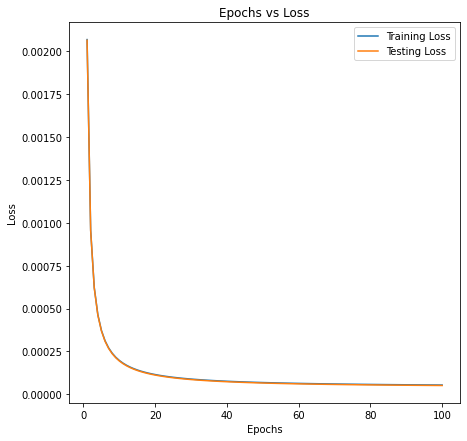

In [7]:
X_train_tensor =torch.from_numpy(X_train).type(torch.FloatTensor)
X_test_tensor =torch.from_numpy(X_test).type(torch.FloatTensor)

at = AutoencoderTorch(num_hidden_neurons=2,input_shape=X.shape,lr = 0.3,epochs=100,test=X_test_tensor)
at.Fit(X_train_tensor)
at.Plot()

In [8]:
Res = pd.DataFrame()
print('\t\t\t\t\t\t\tFinal Comparsion Table\n')
Res['Epochs '] = [(i+1) for i in range(len(ae.trainloss))]
Res['Training Loss \nUsing Numpy(TrN)'] = ae.trainloss
Res['Training Loss \nUsing Autograd(TrA)'] = at.trainloss
Res['Difference = \nabs(TrN-TrA))'] = np.abs(np.array(ae.trainloss)-np.array(at.trainloss))
Res['Testing Loss \nUsing Numpy(TeN)'] = ae.testloss
Res['Testing Loss \nUsing Autograd(TeA)'] = at.testloss
Res['Difference = \nabs(TeN-TeA))'] = np.abs(np.array(ae.testloss)-np.array(at.testloss))
print(tabulate(Res, headers = 'keys', tablefmt = 'psql'))


							Final Comparsion Table

+----+-----------+--------------------+-----------------------+-----------------+--------------------+-----------------------+-----------------+
|    |   Epochs  |     Training Loss  |        Training Loss  |   Difference =  |      Testing Loss  |         Testing Loss  |   Difference =  |
|    |           |   Using Numpy(TrN) |   Using Autograd(TrA) |   abs(TrN-TrA)) |   Using Numpy(TeN) |   Using Autograd(TeA) |   abs(TeN-TeA)) |
|----+-----------+--------------------+-----------------------+-----------------+--------------------+-----------------------+-----------------|
|  0 |         1 |        0.00128849  |           0.00206854  |     0.000780053 |        0.0012844   |           0.0020643   |     0.000779903 |
|  1 |         2 |        0.000616044 |           0.000956899 |     0.000340855 |        0.000612475 |           0.000953179 |     0.000340704 |
|  2 |         3 |        0.000409368 |           0.000622946 |     0.000213578 |        0.00040601